# Mooring system

In [1]:
import numpy as np
import pandas as pd
import math as math
from scipy import optimize
import matplotlib.pylab as plt
from matplotlib.legend_handler import HandlerLine2D

%matplotlib inline
%matplotlib widget
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
pass

In [2]:
# Constants

g=9.81

In [3]:
from MoorLib import moorSeg
from MoorLib import moorLine2D
from MoorLib import moorLine3D

## Solve a 12 line system

We will construct a 12 line system, with each line consisting of 3 segments with differing properties.

The array `segMat` is used to define the order of the segments in the line, starting with the bottom line (line closest to the anchor)

In [4]:
# moorSeg(L_tot=100, W_pm=376, EA=1861000000)
# moorLine3D(xanchor, yanchor, zanchor=0.0, seg=[moorSeg()])

segMat = []
segMat.append( moorSeg(600.0, 376.0, 1725000000) )
segMat.append( moorSeg(1225.0, 10.9, 242000000) )
segMat.append( moorSeg(60.0, 376.0, 1725000000) )

We position 12 lines at a distance of $1585 m$ at various angles w.r.t the global axis.

In [5]:
nLine = 12
lineDist = 1585.94
lineAng = [ 40, 45, 50, 130, 135, 140, 220, 225, 230, 310, 315, 320 ]

lineMat=[]
for iAng in lineAng:
    xan = lineDist * np.cos( iAng * np.pi / 180.0 )
    yan = lineDist * np.sin( iAng * np.pi / 180.0 )
    lineMat.append( moorLine3D( xan, yan, 0.0, seg=segMat ) )

We position the mooring fairleads in a similar manner, w.r.t the global axis.

In [6]:
flDist = 36
V0 = 0.0
for iAng, iLine in zip(lineAng, lineMat):
    xfl = flDist * np.cos( iAng * np.pi / 180.0 )
    yfl = flDist * np.sin( iAng * np.pi / 180.0 )
    zfl = 820
    iLine.solveFl_xyz( V0, xfl, yfl, zfl )

We have now set the default position of the system.

Lets check the net force on the system.

In [7]:
Fx = sum([ iLine.retFlForce()[0] for iLine in lineMat])
Fy = sum([ iLine.retFlForce()[1] for iLine in lineMat])
Fz = sum([ iLine.retFlForce()[2] for iLine in lineMat])
print(Fx, Fy, Fz)

3.346940502524376e-10 3.2014213502407074e-10 -4597495.43223617


Let us also see the characteristics of each individual line

In [8]:
for i in range(0, nLine):
    iLine = lineMat[i]
    print(i, 'LTol', iLine.retLTot(), 'LSusp', iLine.retLSusp(),
          'LBed', iLine.retLBed(), 'H0', iLine.l2d.H0, 'VEnd', iLine.l2d.Ve)

0 LTol 1885.0 LSusp 1293.3563760256075 LBed 591.6436239743927 H0 109514.26433633645 VEnd -383124.6193530143
1 LTol 1885.0 LSusp 1293.3563760256075 LBed 591.6436239743927 H0 109514.26433633696 VEnd -383124.6193530143
2 LTol 1885.0 LSusp 1293.3563760256075 LBed 591.6436239743927 H0 109514.26433633645 VEnd -383124.6193530143
3 LTol 1885.0 LSusp 1293.3563760256075 LBed 591.6436239743927 H0 109514.26433633645 VEnd -383124.6193530143
4 LTol 1885.0 LSusp 1293.3563760256075 LBed 591.6436239743927 H0 109514.26433633645 VEnd -383124.6193530143
5 LTol 1885.0 LSusp 1293.3563760256075 LBed 591.6436239743927 H0 109514.26433633645 VEnd -383124.6193530143
6 LTol 1885.0 LSusp 1293.3563760256075 LBed 591.6436239743927 H0 109514.26433633645 VEnd -383124.6193530143
7 LTol 1885.0 LSusp 1293.3563760256075 LBed 591.6436239743927 H0 109514.26433633645 VEnd -383124.6193530143
8 LTol 1885.0 LSusp 1293.3563760256075 LBed 591.6436239743927 H0 109514.26433633645 VEnd -383124.6193530143
9 LTol 1885.0 LSusp 1293.356

This is the stable position for hte system, with $0$ horizontal force. <br>
We will store this stable position for each fairlead.<br>
We can then move the system about the stable position to generate the force excursion diagram.

We also save the stable solution of `H0` and `LBed` for each line.<br>
This will be used as an initial guess for the solver in any further computation.

In [9]:
for iLine in lineMat:
    iLine.setFlRef_xyz( iLine.xfl, iLine.yfl, iLine.zfl)
    iLine.H0Start = iLine.l2d.H0
    iLine.LBedStart = iLine.retLBed()

## Force excursion diagram

We evaluate the surge force excursion diagram as follows.

In [10]:
def calcSysRestoringForce( trans_xyz, msg=False ):
    V0 = 0.0
    for iLine in lineMat:
        xfl = iLine.xflRef + trans_xyz[0]
        yfl = iLine.yflRef + trans_xyz[1]
        zfl = iLine.zflRef + trans_xyz[2]
        iLine.solveFl_xyz( V0, xfl, yfl, zfl, 
                          H0Start = iLine.H0Start, LBedStart = iLine.LBedStart )
    
    Fx = sum([ iLine.retFlForce()[0] for iLine in lineMat])
    Fy = sum([ iLine.retFlForce()[1] for iLine in lineMat])
    Fz = sum([ iLine.retFlForce()[2] for iLine in lineMat])    
    
    
    if(msg):
        #print( min([iLine.retLBed() for iLine in lineMat]) )
        for iLine in lineMat:            
            print( iLine.xfl, iLine.yfl, iLine.zfl, 
                  iLine.l2d.xe, iLine.l2d.ze, iLine.l2d.H0, iLine.retLBed() )
            
        
    return Fx, Fy, Fz

In [11]:
dx = np.arange(-100, 100+0.2, 0.2)

FRes = [ calcSysRestoringForce([idx, 0.0, 0.0]) for idx in dx ]

/home/shagun/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


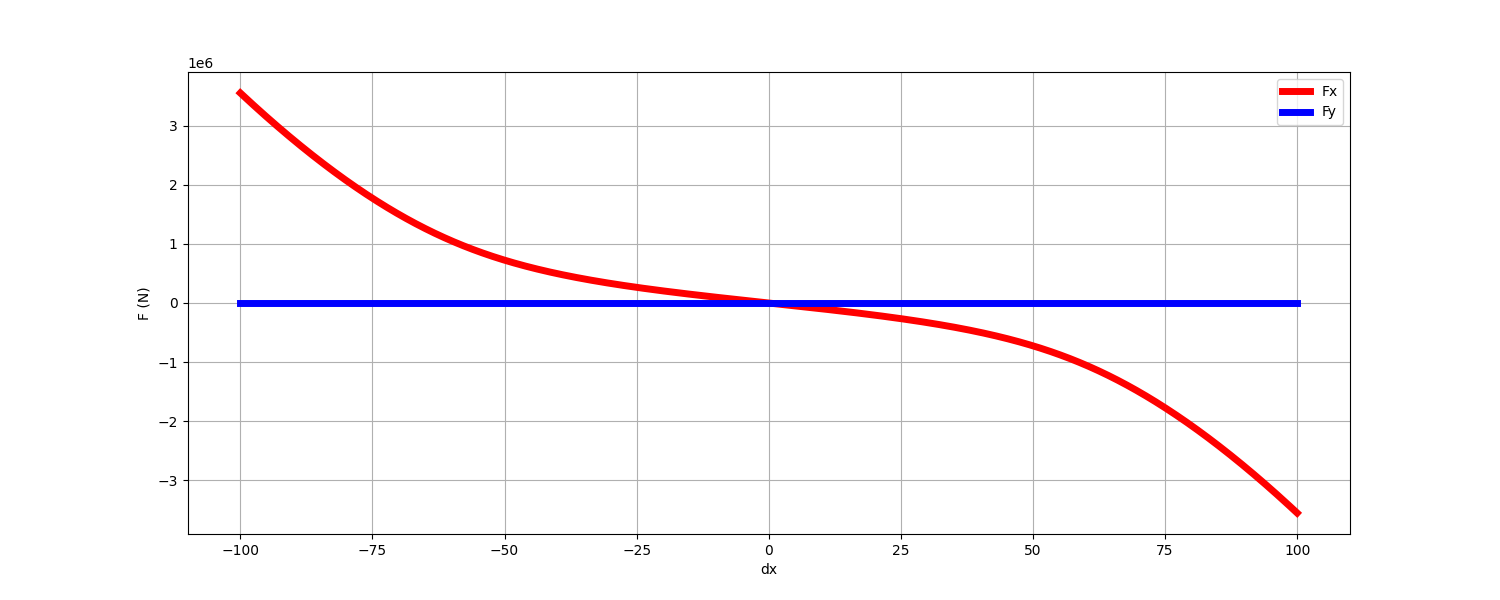

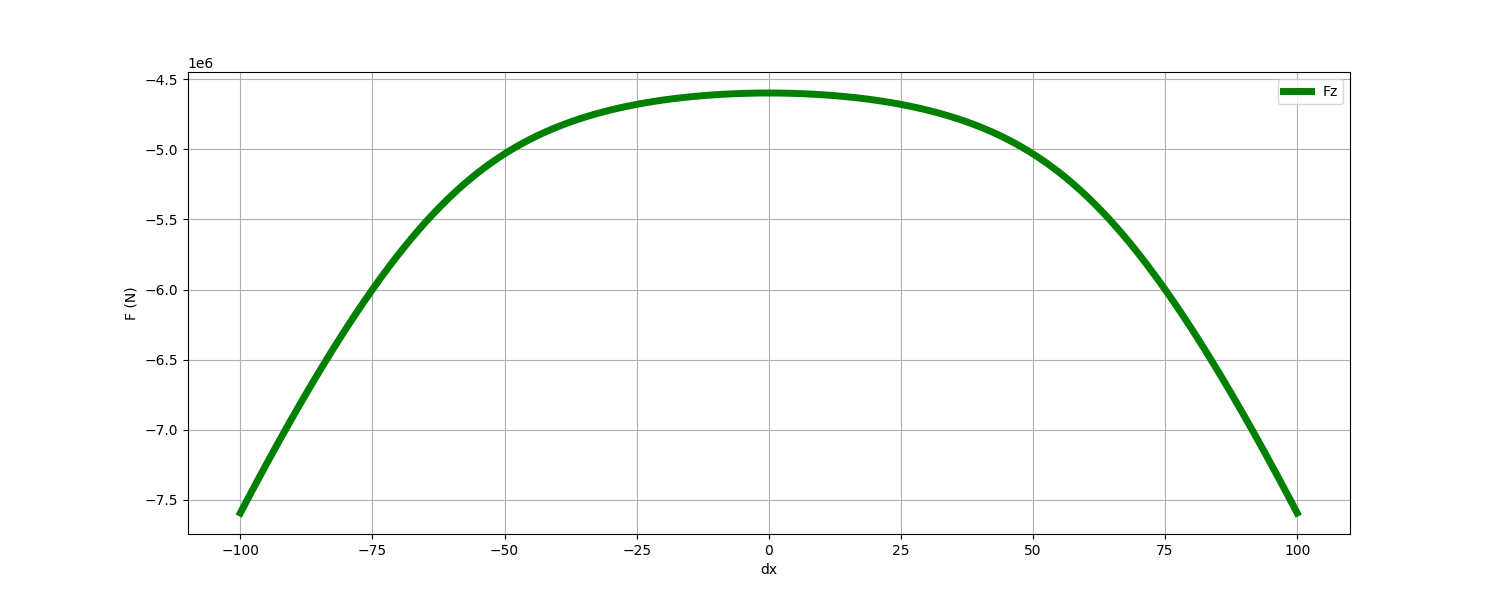

In [12]:
plt.subplots(1,1)
plt.plot( dx, [fx for fx,fy,fz in FRes], 'r-', lw=5, label='Fx')
plt.plot( dx, [fy for fx,fy,fz in FRes], 'b-', lw=5, label='Fy')
plt.grid("on")
plt.xlabel('dx')
plt.ylabel('F (N)')
plt.legend()

plt.subplots(1,1)
plt.plot( dx, [fz for fx,fy,fz in FRes], 'g-', lw=5, label='Fz')
plt.grid("on")
plt.xlabel('dx')
plt.ylabel('F (N)')
plt.legend()
pass

## Visualize the system

Translation about stable position [185, 0.0, 0.0]
212.5775999522832 23.140353948715415 820.0 1413.2337109119296 820.0000000000003 35789.9031038363 781.9284067265772
210.45584412271572 25.455844122715714 820.0 1425.1417341303327 820.0000000000056 38956.41463066967 760.4049131558646
208.14035394871541 27.57759995228321 820.0 1438.0245405867397 820.0 42687.43036036402 735.5730598444125
161.85964605128459 27.57759995228321 820.0 1674.862211607312 820.0000000000507 2622735.766650546 167.21811132814852
159.54415587728428 25.455844122715718 820.0 1685.8377872259723 820.0000000002664 3115080.2695242884 100.33234153670591
157.4224000477168 23.140353948715422 820.0 1695.8326820593659 820.0000000004142 3603246.612251743 37.2120579294362
157.4224000477168 -23.140353948715415 820.0 1695.8326820593659 820.0000000004142 3603246.612251743 37.2120579294362
159.54415587728428 -25.45584412271571 820.0 1685.8377872259723 820.0000000002664 3115080.2695242884 100.33234153670591
161.85964605128459 -27.577599

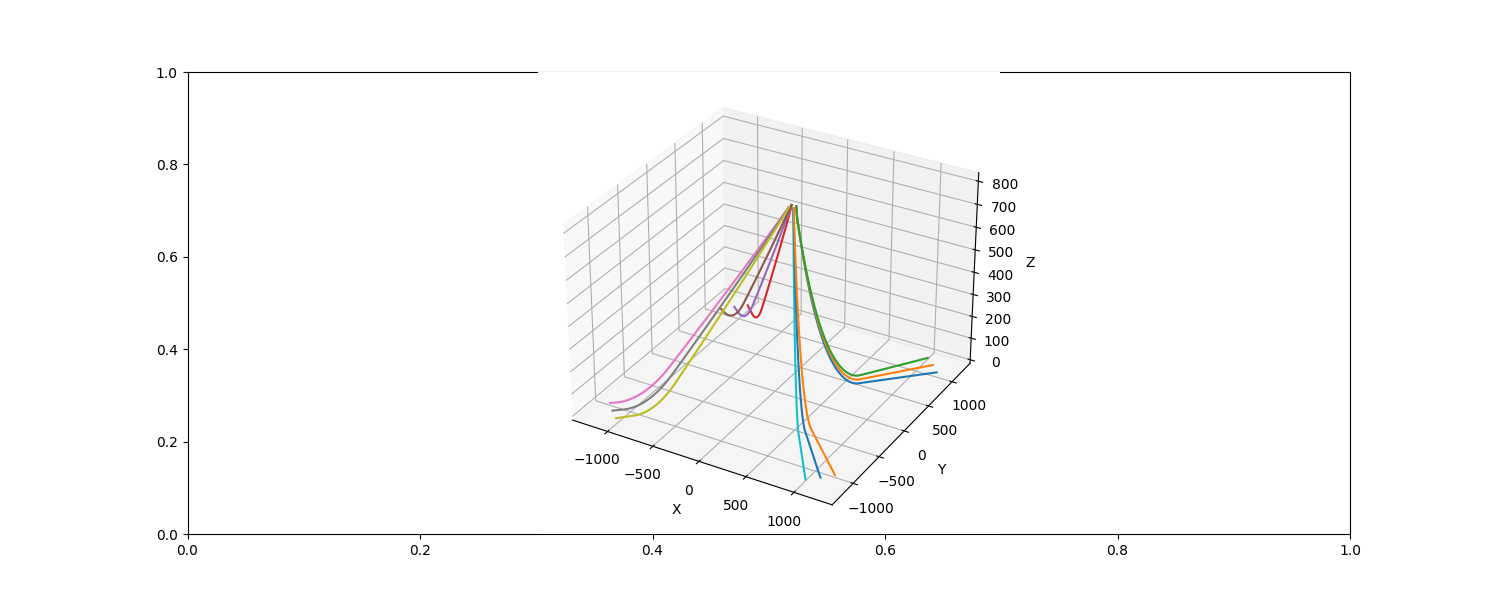

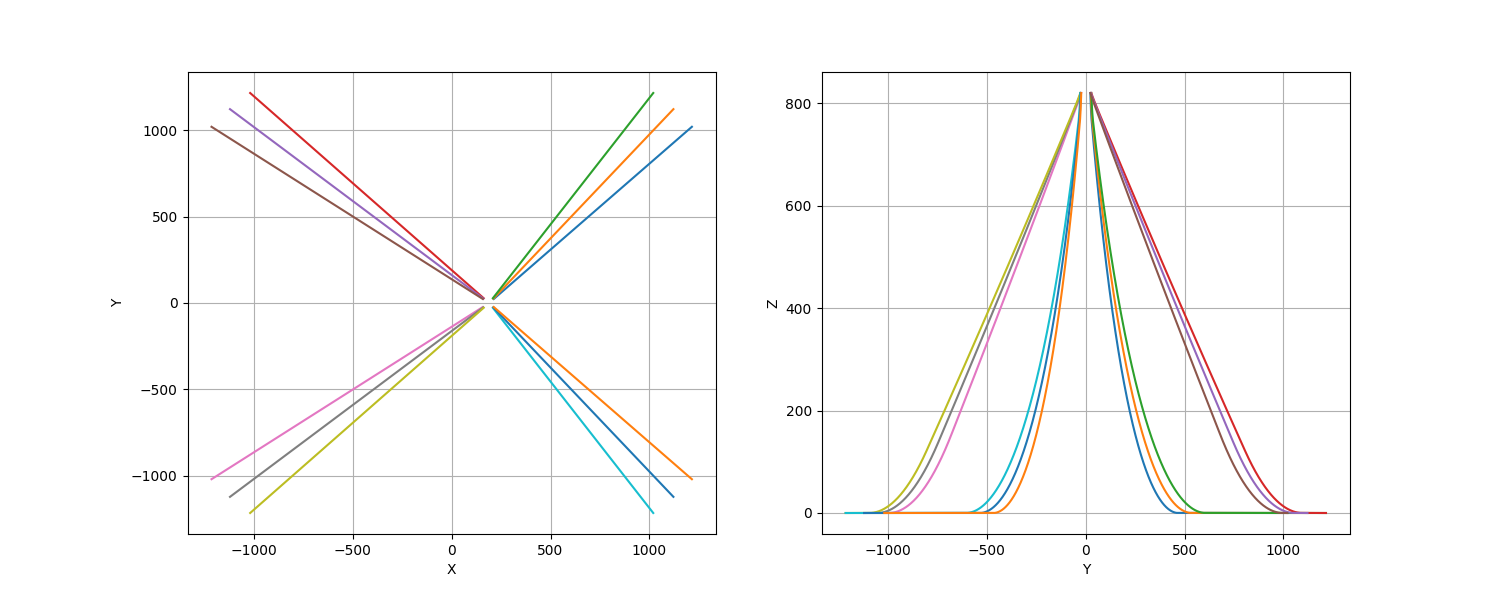

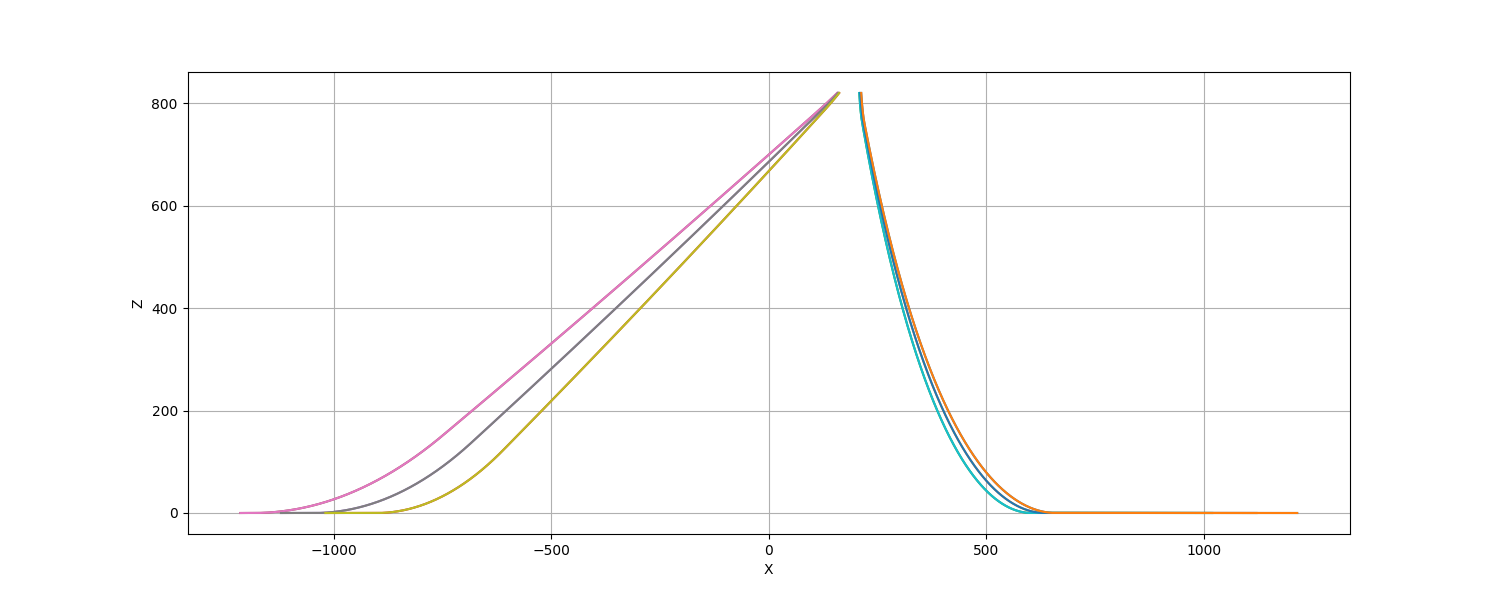

In [13]:
trans_xyz = [185, 0.0, 0.0]
print('Translation about stable position', trans_xyz)
print( calcSysRestoringForce( trans_xyz, msg=True ) )


# 3D plot of the system
plt.subplots(1,1)
ax = plt.axes(projection='3d')
#ax.view_init(90, 270)
for iLine in lineMat:
    x,y,z,segTyp = iLine.plotLine3D(0.1)    
    plt.plot(x,y,z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.grid("on")
#plt.axis("equal")

# 2D Views
f, (ax1, ax2) = plt.subplots(1,2)
for iLine in lineMat:
    x,y,z,segTyp = iLine.plotLine3D(0.1)    
    ax1.plot(x,y)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.grid()

for iLine in lineMat:
    x,y,z,segTyp = iLine.plotLine3D(0.1)    
    ax2.plot(y,z)
ax2.set_xlabel('Y')
ax2.set_ylabel('Z')
ax2.grid()

plt.subplots(1,1)
for iLine in lineMat:
    x,y,z,segTyp = iLine.plotLine3D(0.1)    
    plt.plot(x,z)
plt.xlabel('X')
plt.ylabel('Z')
plt.grid()


pass